## 5.0.Informative signal clustering

Using replicate 3 (numbered from 1), get 10% most informative signals identified as the ones with higher confidence (more homogeneous neighbors) found using 10-fold split in the data.

In [1]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

from collections import Counter

import sys 
sys.path.append('..')
from src.constants import SAMPLES_DICT_3CLASS
from src.knn_load_data import (
    INDICES_SAVE_PATH_3CLASS, DTW_SAVE_PATH_3CLASS,
    load_data, prefix_data_dir, load_np_data
)
from src.knn_classifier import (
    knn_classifier_ontest, cluster_venn
)
from src.kmedoids_mod import KMedoids_mod
from src.signal_processing import SignalProcessor

In [2]:
SAMPLES_DICT_3CLASS = prefix_data_dir(SAMPLES_DICT_3CLASS, "/mmfs1/gscratch/ml4ml/cailinw/pore_data/")

## Prepare data

### Subsetting sample 2 only

In [3]:
data, labels_ori, samples_ori, indices_ori, labels_key = load_data(
    samples_dict=SAMPLES_DICT_3CLASS,
    save_dir=INDICES_SAVE_PATH_3CLASS,
    load_raw_signals=False
)

dtw_mat_ori = load_np_data(f"{DTW_SAVE_PATH_3CLASS}nonorm_nosmooth_100_nopad_3class.npy")
num_classes = 3
num_samples = 1

class_names=['heart', 'adrenal', 'aorta']
num_classes=3
num_samples=[4, 4, 4]
In progress...
 
 lass heart, replicate 4/4
 lass adrenal, replicate 4/4


In [4]:
chosen_sample = 2

In [5]:
sample_selector = (samples_ori == chosen_sample)

In [6]:
labels = labels_ori[sample_selector]

In [7]:
samples = samples_ori[sample_selector]

In [8]:
indices = indices_ori[sample_selector]

In [9]:
dtw_mat = dtw_mat_ori[np.ix_(sample_selector,sample_selector)]

In [10]:
print(dtw_mat.shape)
print(samples.shape)

(9840, 9840)
(9840,)


In [11]:
labels_key

{0: 'heart', 1: 'adrenal', 2: 'aorta'}

In [12]:
pd.Series(labels).value_counts()

0    3280
1    3280
2    3280
dtype: int64

In [13]:
pd.Series(samples).value_counts()

2    9840
dtype: int64

In [14]:
labels

array([0, 0, 0, ..., 2, 2, 2])

In [15]:
samples

array([2, 2, 2, ..., 2, 2, 2])

### Get informative signals

In [16]:
num_splits = 10

In [17]:
k_neighbors = 59
num_classes = 3
knn_weights = 'uniform'

In [18]:
num_signals_vals = np.arange(15,940,1)
num_signals_vals.shape

(925,)

A 10% is 984 signals, which split between 10 datasets to get the total of 984 corresponds to taking only 98 signals from each set.

In [19]:
dtw_mat.shape[0] / 10 / 10

98.4

In [20]:
acc_rslt_all = []
precision_rslt_all = []
recall_rslt_all = []
fscore_rslt_all = []
numclass0_rslt_al = []
numclass1_rslt_al = []
numclass2_rslt_al = []

# list to get the informative signals, relative to the DTW indices
informative_signals_dtwindex = []
# determine we only want 98 signals
informative_signals_persplit = 98

skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

for cv_i, (train_index, test_index) in enumerate(skf.split(dtw_mat, labels)):
    print(f"Now evaluating with split {cv_i+1}/{num_splits}")
    X_train = dtw_mat[np.ix_(train_index, train_index)]
    y_train = labels[train_index]
    # test matrix is test vs train distances
    X_test = dtw_mat[np.ix_(test_index, train_index)]
    y_test = labels[test_index]
    
    probs_record, metrics_record = knn_classifier_ontest(
        X_train,
        y_train,
        X_test,
        y_test,
        k_neighbors,
        num_classes,
        knn_weights
    )

    # now calculate precison and other metrics...
    pred_class = probs_record['pred_class']
    pred_conf = probs_record['pred_conf']
    true_class = probs_record['true_class']
    
    # indices to sort by decreasing order of confidences, maintaining dimensions
    sort_idx = np.argsort(pred_conf)[...,::-1]

    # sort both the predicted and true labels in decreasing order of confidence
    pred_sorted = np.take_along_axis(pred_class, sort_idx, axis=-1)
    true_sorted = np.take_along_axis(true_class, sort_idx, axis=-1)

    # get informative signals indices
    informative_signals_dtwindex.append(test_index[sort_idx[:informative_signals_persplit]])
    
    # ## Some metrics
    # # discard by confidence 
    # accuracy_bysignal = []
    # precision_bysignal = []
    # recall_bysignal = []
    # fscore_bysignal = []
    # numclass0_bysignal = []
    # numclass1_bysignal = []
    # numclass2_bysignal = []
    # for num_sig in num_signals_vals:
    #     accuracy_bysignal.append(np.mean(pred_sorted[...,:num_sig] == true_sorted[...,:num_sig]))
    #     precision, recall, fscore, support = score(true_sorted[...,:num_sig], pred_sorted[...,:num_sig])
    #     precision_bysignal.append(np.mean(precision))
    #     recall_bysignal.append(np.mean(recall))
    #     fscore_bysignal.append(np.mean(fscore))
    #     numclass0_bysignal.append(support[0])
    #     numclass1_bysignal.append(support[1])
    #     numclass2_bysignal.append(support[2])
    # precision_rslt_all.append(precision_bysignal)
    # recall_rslt_all.append(recall_bysignal)
    # fscore_rslt_all.append(fscore_bysignal)
    # numclass0_rslt_al.append(numclass0_bysignal)
    # numclass1_rslt_al.append(numclass1_bysignal)
    # numclass2_rslt_al.append(numclass2_bysignal)

Now evaluating with split 1/10
Now evaluating with split 2/10
Now evaluating with split 3/10
Now evaluating with split 4/10
Now evaluating with split 5/10
Now evaluating with split 6/10
Now evaluating with split 7/10
Now evaluating with split 8/10
Now evaluating with split 9/10
Now evaluating with split 10/10


In [21]:
informative_signals_dtwindex = np.concatenate(informative_signals_dtwindex)

In [22]:
len(np.unique(informative_signals_dtwindex)) == len(informative_signals_dtwindex)

True

I sort it to preserve the orientation

In [23]:
informative_signals_dtwindex = np.sort(informative_signals_dtwindex)

Get the matrix of only informative, and the labels, and etc...

In [24]:
dtw_mat_inform = dtw_mat[np.ix_(informative_signals_dtwindex,informative_signals_dtwindex)]

In [25]:
labels_inform = labels[informative_signals_dtwindex]

Balance of classes that I already expected, this means I selected them correctly with the indices!

In [26]:
pd.Series(labels_inform).value_counts()

2    443
1    298
0    239
dtype: int64

## Clustering only informative signals

In [27]:
# more detail
cluster_list = np.arange(2,100,1)

In [28]:
inertia_clust = []
silhouette_clust = []

for clst_n in cluster_list:
    kmedoids = KMedoids_mod(n_clusters=clst_n, random_state=0, metric='precomputed', max_iter=300).fit(dtw_mat_inform)
    assigned_labels = kmedoids.labels_
    silhouette_clust.append(silhouette_score(dtw_mat_inform, assigned_labels, metric='precomputed'))
    inertia_clust.append(kmedoids.inertia_)

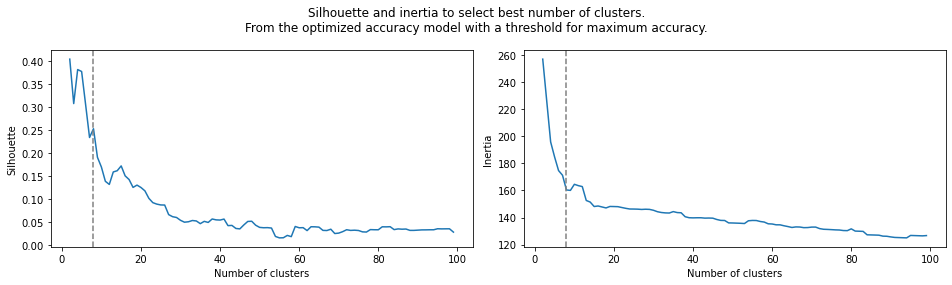

In [29]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=plt.figaspect(0.3))
ax0.plot(cluster_list, silhouette_clust)
ax0.set_ylabel("Silhouette")
ax0.set_xlabel("Number of clusters")
ax1.plot(cluster_list, inertia_clust)
ax1.set_ylabel("Inertia")
ax1.set_xlabel("Number of clusters")
ax0.axvline(8, c='gray', ls='--')
ax1.axvline(8, c='gray', ls='--')
plt.suptitle('Silhouette and inertia to select best number of clusters.\nFrom the optimized accuracy model with a threshold for maximum accuracy.')
plt.tight_layout()
plt.show()

### Plot side by side the clusters and the samples with informative signals

In [30]:
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components,
            metric='precomputed', 
            perplexity=8,
            early_exaggeration=24,
            random_state=42,
            init='random',
            learning_rate='auto',
            square_distances=True
           )
tsne_result = tsne.fit_transform(dtw_mat_inform)
tsne_result.shape

(980, 2)

Retaining 10% most informative signals, tSNE visualization and clustering.

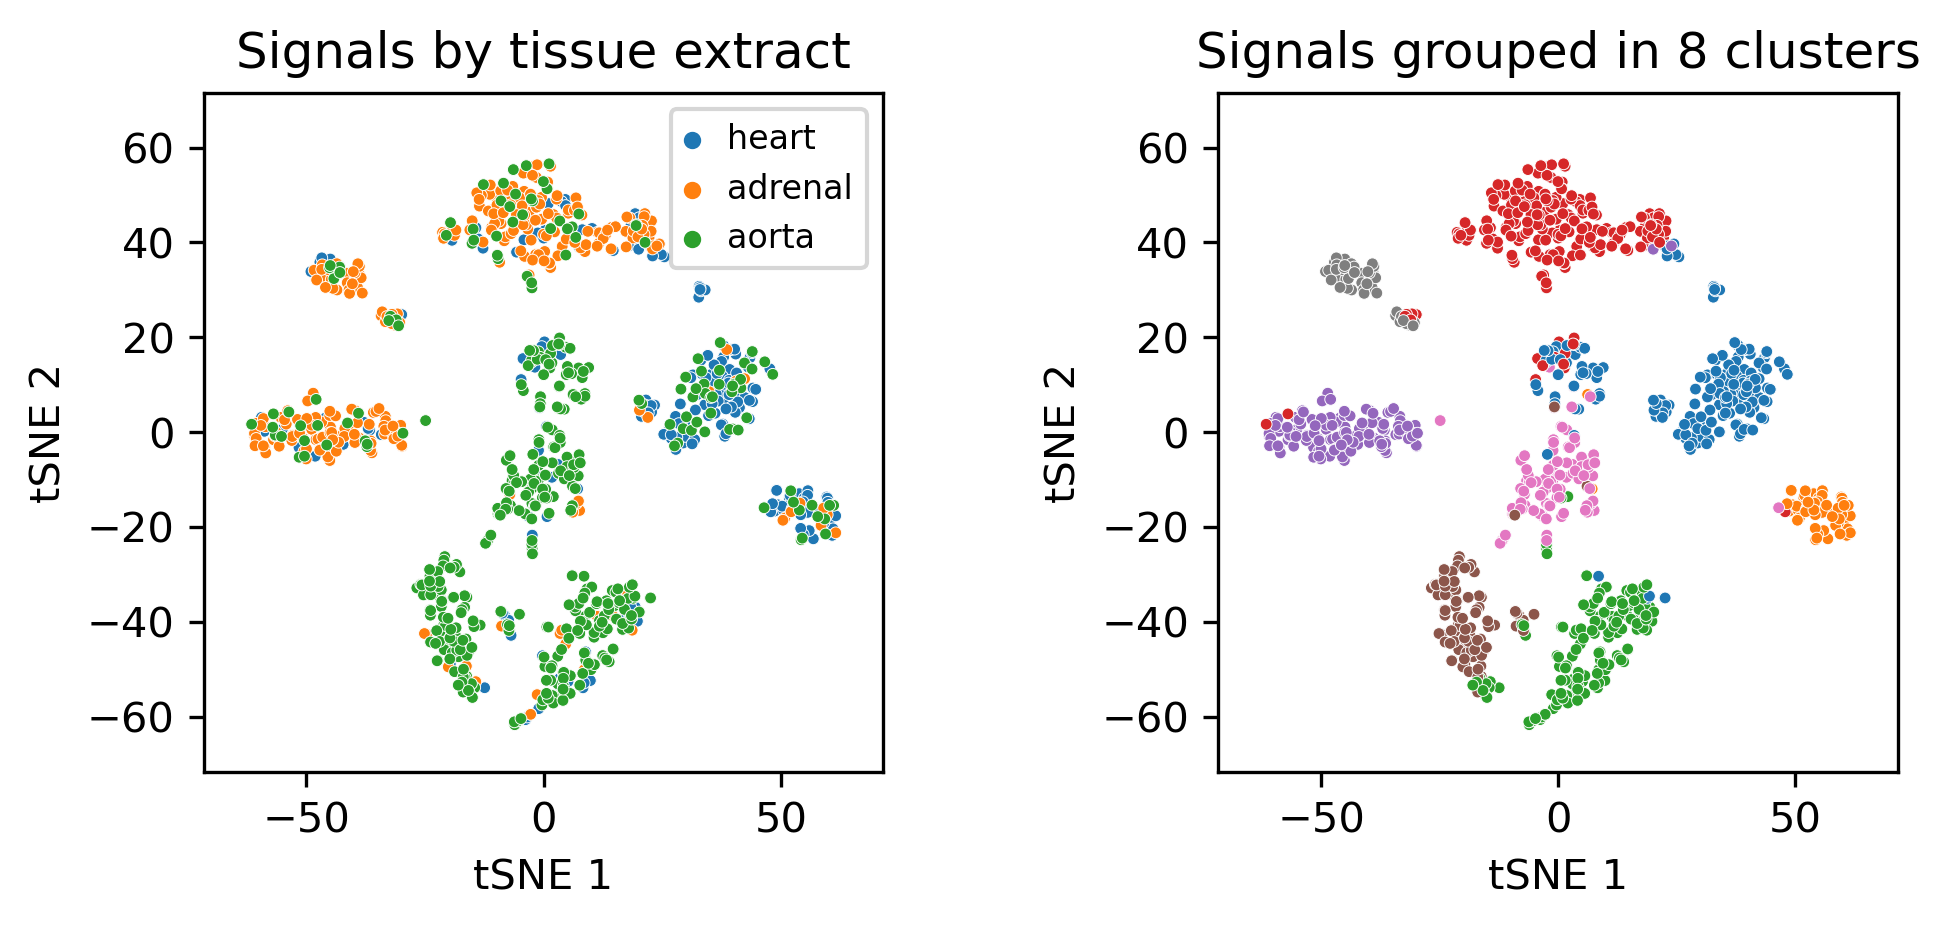

In [31]:
clust_number = 8

s = 8

fig, axs = plt.subplots(1,2, figsize=(8,3), dpi=300)
kmedoids = KMedoids_mod(n_clusters=clust_number, random_state=0, metric='precomputed', max_iter=300).fit(dtw_mat_inform)
clust_labels = kmedoids.labels_
clust_centers = kmedoids.cluster_centers_
# print("Number of signals per cluster:", Counter(clust_labels))
# print("Signals that act as the cluster centers:", clust_centers)
name_labels = [labels_key[lab] for lab in labels[informative_signals_dtwindex]]
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': name_labels})
sns.set_palette("tab10")
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=axs[0],s=s)
name_labels = [str(cl) for cl in clust_labels]
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': name_labels})
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=axs[1],s=s)
axs[0].set_title('Signals by tissue extract')
axs[1].set_title(f'Signals grouped in {clust_number} clusters')
for i in range(2):
    lim = (tsne_result.min()-10, tsne_result.max()+10)
    axs[i].set_xlim(lim)
    axs[i].set_ylim(lim)
    axs[i].set_xlabel('tSNE 1')
    axs[i].set_ylabel('tSNE 2')
    axs[i].set_aspect('equal')
    if i==1: axs[i].legend([],[], frameon=False)
    
handles, leg_labels = axs[0].get_legend_handles_labels()
lgnd = axs[0].legend(loc='upper right', handles=handles, labels=leg_labels, fontsize=8, handlelength=0.5)
for handle in lgnd.legendHandles:
    handle.set_sizes([s+2])
    
plt.savefig('../figs/knn5.InfOnly_clust.png',dpi=300, bbox_inches='tight')
plt.show()

## Study cluster composition

In [32]:
sns.set_palette("tab10")

In [33]:
clust_number = 8

kmedoids = KMedoids_mod(n_clusters=clust_number, random_state=0, metric='precomputed', max_iter=300).fit(dtw_mat_inform)
clust_labels = kmedoids.labels_
clust_centers = kmedoids.cluster_centers_

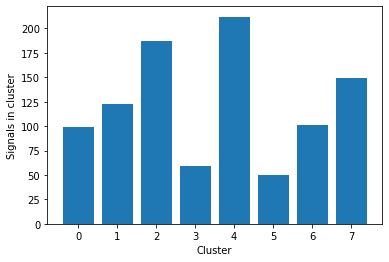

In [34]:
plt.bar(Counter(clust_labels).keys(), Counter(clust_labels).values())
plt.xlabel('Cluster')
plt.ylabel('Signals in cluster')
plt.show()

In [35]:
# 2D array, first dimension for each cluster, second for each label
num_labels = len(labels_key.values())
lbl_by_cluster = np.zeros((clust_number,num_labels))
for signal_label, signal_cluster in zip(labels_inform, clust_labels):
    lbl_by_cluster[signal_cluster, signal_label] += 1
lbl_by_cluster_norm = normalize(lbl_by_cluster, axis=1, norm='l1')
lbl_by_cluster_norm_df = pd.DataFrame(lbl_by_cluster_norm)

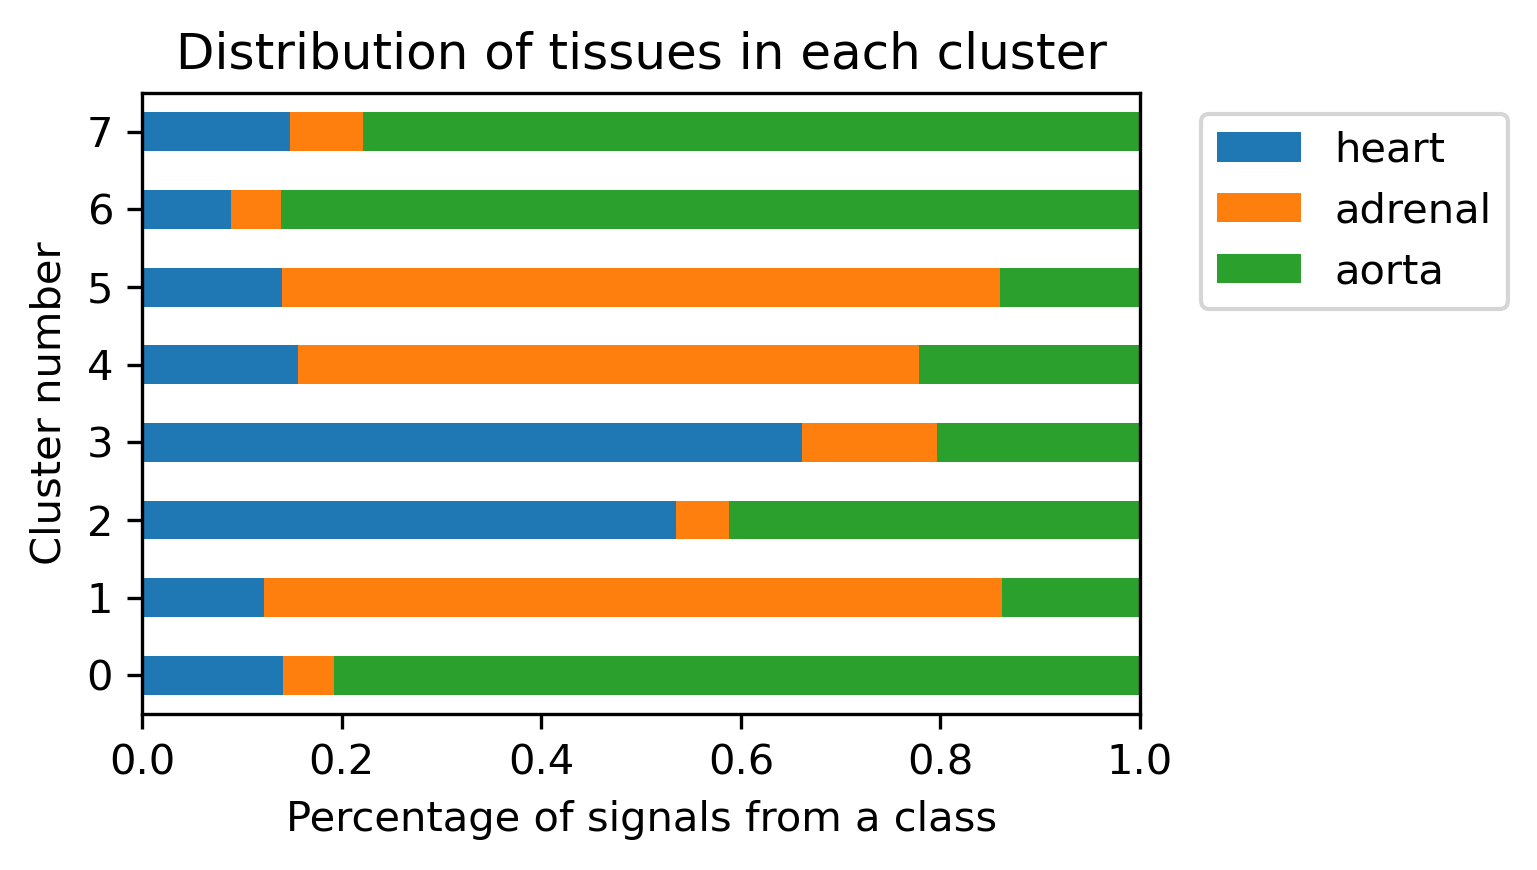

In [36]:
fig = plt.figure(figsize=(4,3), dpi=300)
lbl_by_cluster_norm_df = pd.DataFrame(lbl_by_cluster_norm)
lbl_by_cluster_norm_df.rename(columns=labels_key).plot.barh(stacked=True, ax = plt.gca())
plt.ylabel("Cluster number")
plt.xlabel("Percentage of signals from a class")
plt.legend(title="Classes")
plt.title("Distribution of tissues in each cluster")
plt.tight_layout()
plt.xlim(0,1)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

In [37]:
lbl_by_cluster_norm2 = normalize(lbl_by_cluster, axis=0, norm='l1')
lbl_by_cluster_norm2_df = pd.DataFrame(lbl_by_cluster_norm2)

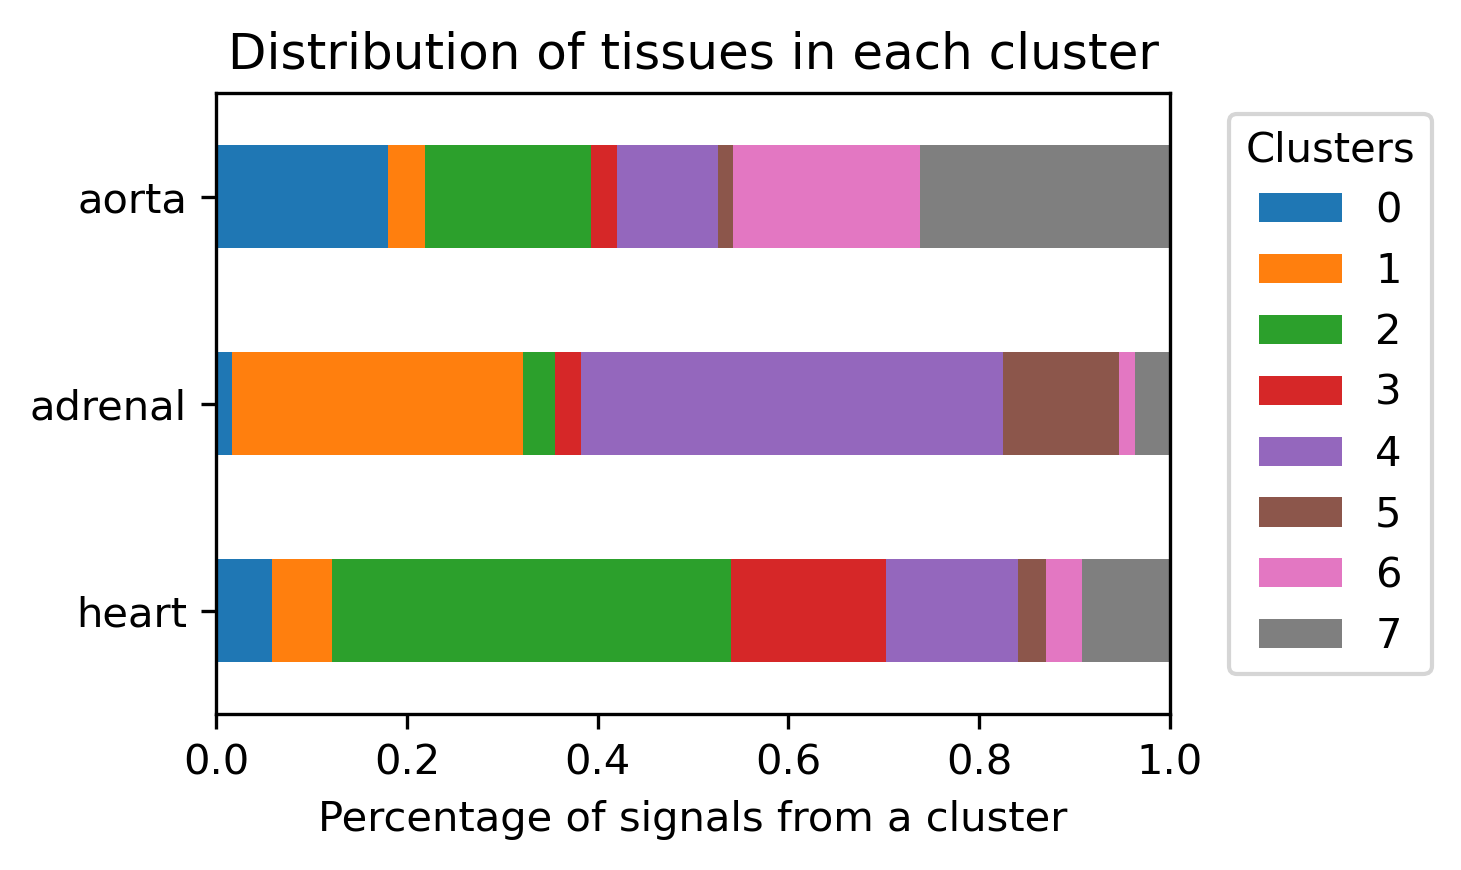

In [38]:
fig = plt.figure(figsize=(5,3), dpi=300)
lbl_by_cluster_norm2_df = pd.DataFrame(lbl_by_cluster_norm2)
lbl_by_cluster_norm2_df.rename(columns=labels_key).T.plot.barh(stacked=True, ax = plt.gca())
plt.ylabel("")
plt.xlabel("Percentage of signals from a cluster")
plt.legend(title="Clusters", bbox_to_anchor=(1.04,1), loc="upper left")
plt.title("Distribution of tissues in each cluster")
plt.tight_layout()
plt.xlim(0,1)
plt.legend
plt.savefig('../figs/knn6.TissuesInClusters_perc.png',dpi=300, bbox_inches='tight')
plt.show()

# Visualizing signals per each cluster (centroids and the rest)

### Loading signals

Before loaded all info but not the signal

In [39]:
data_all, labels_ori, samples_ori, indices_ori, labels_key = load_data(
    samples_dict=SAMPLES_DICT_3CLASS,
    save_dir=INDICES_SAVE_PATH_3CLASS,
    load_raw_signals=True
)

class_names=['heart', 'adrenal', 'aorta']
num_classes=3
num_samples=[4, 4, 4]
In progress...
 
 lass heart, replicate 4/4
 lass adrenal, replicate 4/4


In [40]:
signal_processor = SignalProcessor(
    norm_method='nonorm',
    downsample=True, downsample_rate=1000,
    pad=True, pad_value=2, pad_len=100,
)
data_proc_all, labels_ori_proc, samples_ori_proc, indices_ori_proc = signal_processor.transform(data_all, labels_ori, samples_ori, indices_ori)

100%|██████████| 39360/39360 [00:00<00:00, 54372.75it/s]


In [41]:
print(dtw_mat_ori.shape)
print(data_all.shape)
print(data_proc_all.shape)

(39360, 39360)
(39360,)
(39360, 100)


Filter them to sample two only

In [42]:
chosen_sample = 2
sample_selector = (samples_ori == chosen_sample)
data_proc = data_proc_all[sample_selector]
data = data_all[sample_selector]

In [43]:
print(dtw_mat.shape)
print(data.shape)
print(data_proc.shape)

(9840, 9840)
(9840,)
(9840, 100)


In [44]:
indices.shape

(9840,)

**Filter them to only informative signals**

In [45]:
data_inform = data[informative_signals_dtwindex]
data_proc_inform = data_proc[informative_signals_dtwindex]

#### Plot only the cluster centroids

In [46]:
clust_number = 8

kmedoids = KMedoids_mod(n_clusters=clust_number, random_state=0, metric='precomputed', max_iter=300).fit(dtw_mat_inform)
clust_labels = kmedoids.labels_
clust_centers = kmedoids.cluster_centers_

In [47]:
clust_centers

array([844, 457, 821, 197, 426, 630, 546,  61])

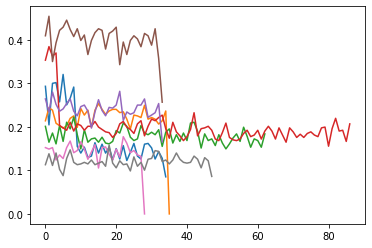

In [48]:
for signal in data_proc_inform[clust_centers]:
    plt.plot(signal[signal != 2])

In [49]:
# maximum length will be the total signal length
max_len = data_proc_inform.shape[1]

Signals were padded with a value that cannot be taken to get them into a numpy array of the same size. Here, remove the pad to visualize only the signal (which is what was used to calculate DTW distance)

In [50]:
def remove_pad(signal, pad_val = 2.0):
    return signal[signal != 2.0]

For clarity, plot only 1/10 of signals in each cluster, and downsample them to 1/150 values, which makes for a clear visualization.

In [51]:
sns.set_palette("bright")

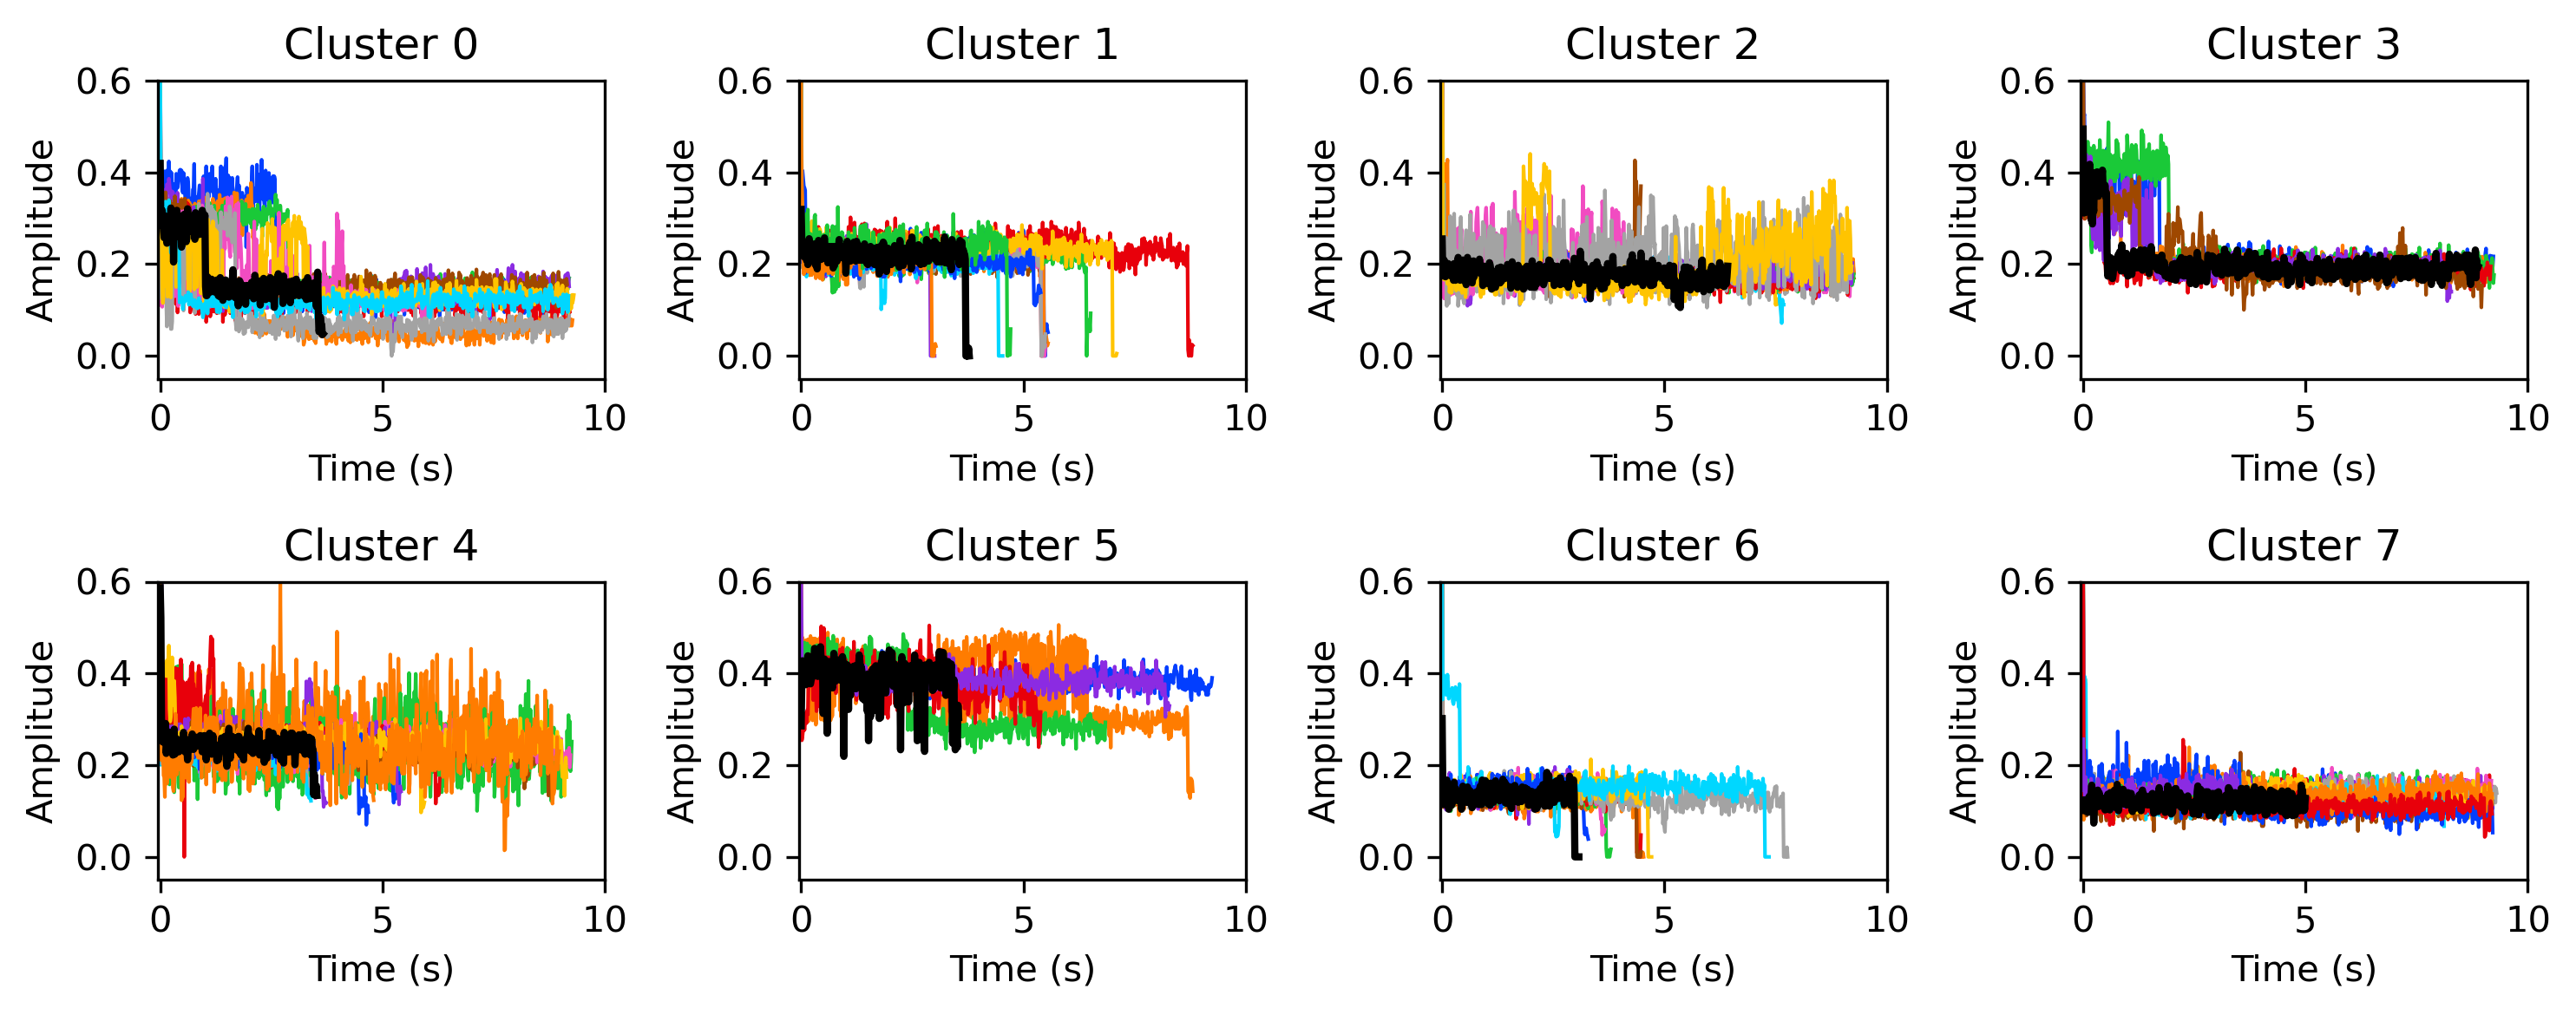

In [52]:
# fig, axs = plt.subplots(2,4, figsize=(10,4), dpi=200)
fig, axs = plt.subplots(2,4, figsize=(10,4), dpi=300)

frac = 10

sec_per_obs = 1e4

downsampling = 150
    
axs = axs.flatten()
for i in np.unique(clust_labels):
    # plot 1/frac of the signals in the cluster
    clust_signals = np.argwhere(clust_labels == i)
    for sig in clust_signals[::frac]:
        axs[i].plot(np.arange(len(data_inform[sig[0]]))[::downsampling]/ sec_per_obs,
                    data_inform[sig[0]][::downsampling], lw=1)
        
    # overlay the centroid signal
    centroid_idx = clust_centers[i]
    axs[i].plot(np.arange(len(data_inform[centroid_idx]))[::downsampling]/ sec_per_obs,
                data_inform[centroid_idx][::downsampling], c='black', lw=2)
    axs[i].set_title(f'Cluster {i}')
    axs[i].set_xlim((-0.05,10))
    axs[i].set_ylim((-0.05,0.6))
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Amplitude')
    
plt.tight_layout()
plt.savefig('../figs/knn7.ClusterSignals.png',dpi=300, bbox_inches='tight')
plt.show()    

Here is the same image but without downsampling.

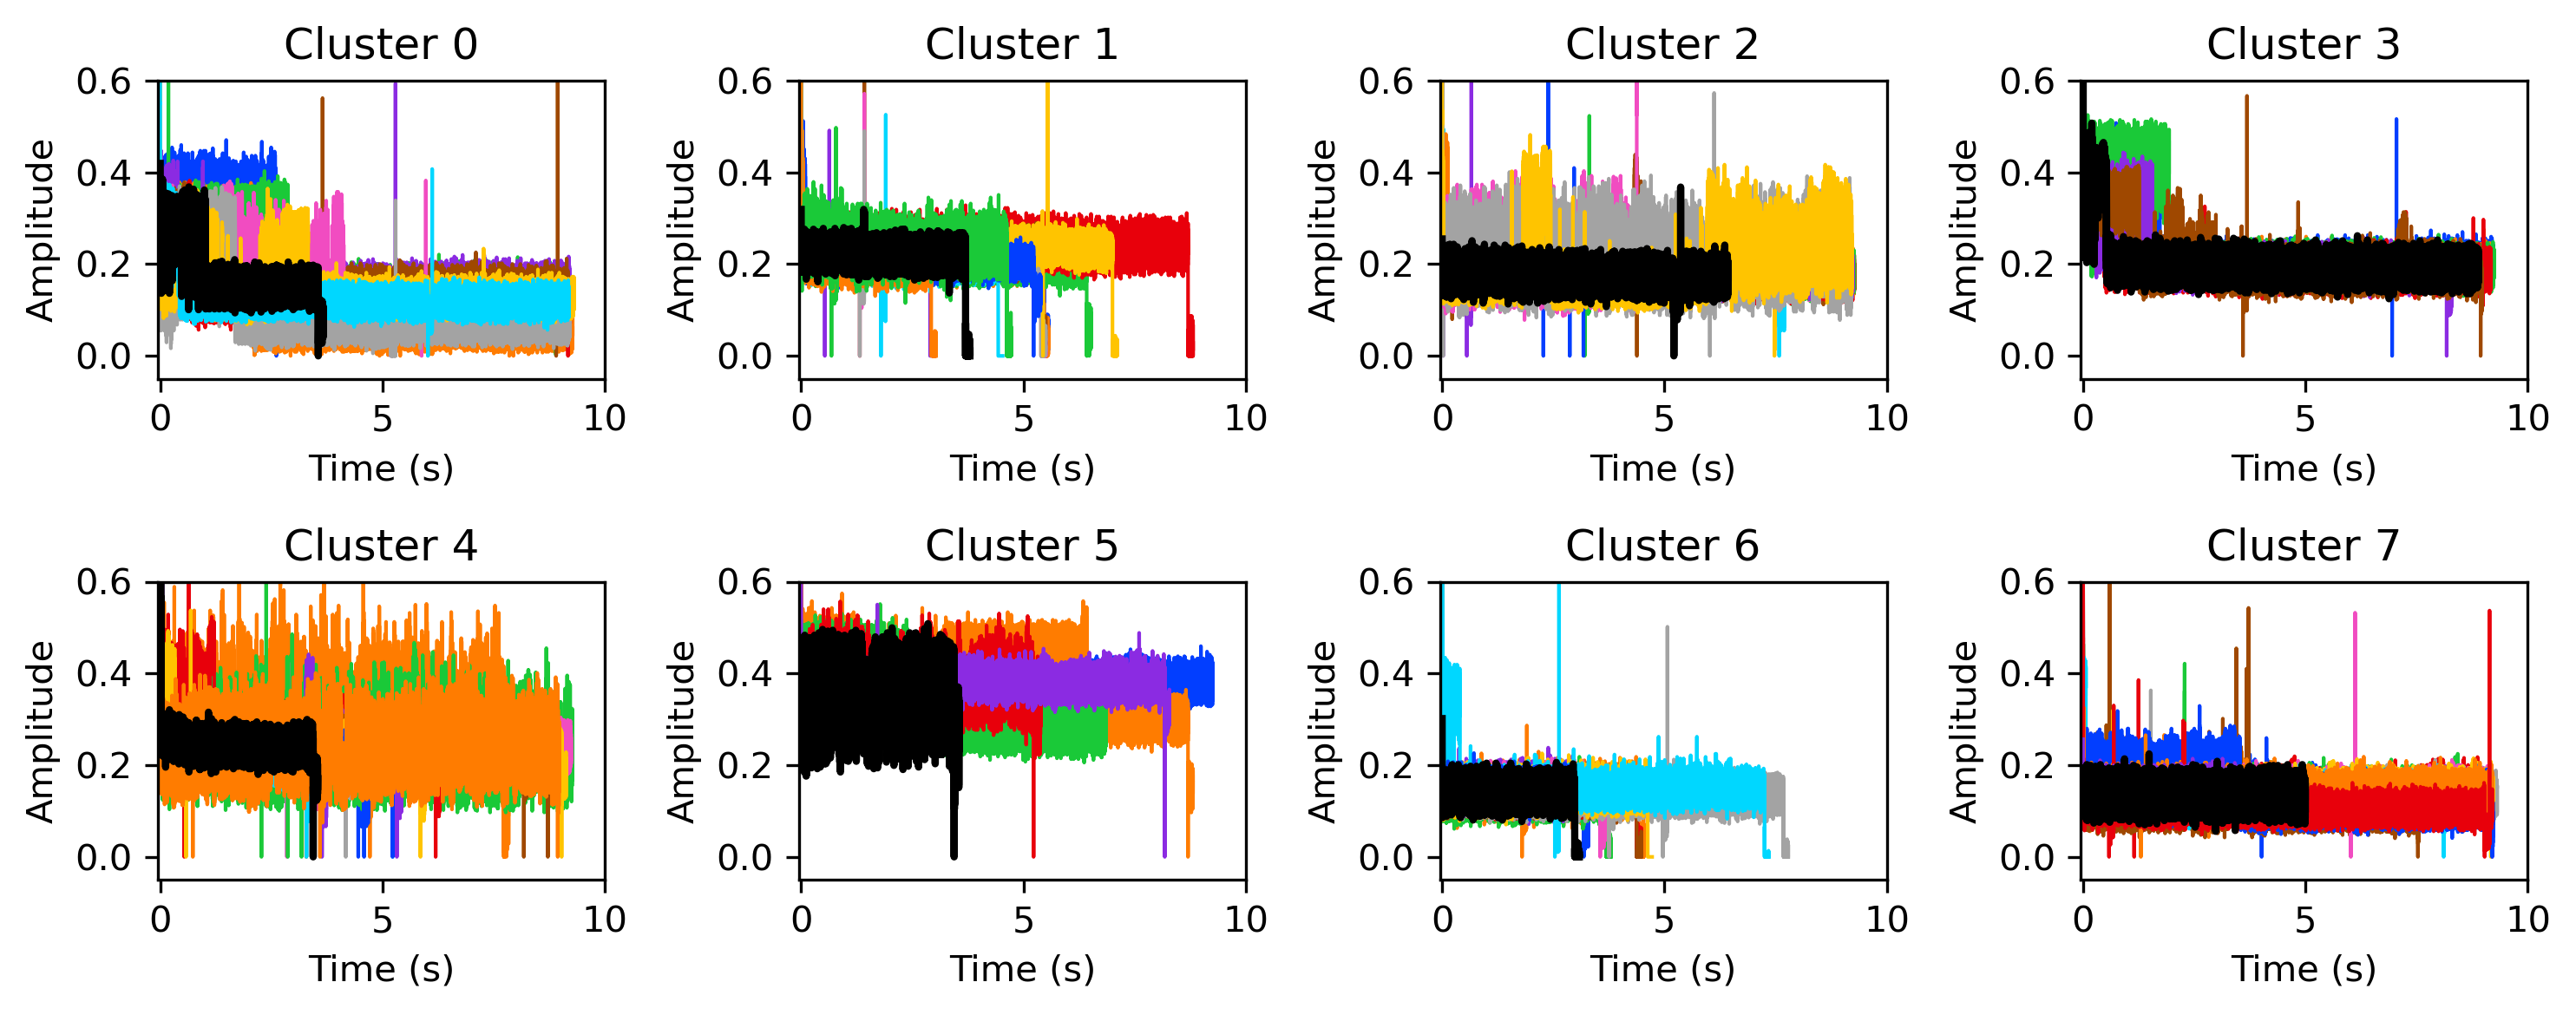

In [53]:
# fig, axs = plt.subplots(2,4, figsize=(10,4), dpi=200)
fig, axs = plt.subplots(2,4, figsize=(10,4), dpi=300)

frac = 10

sec_per_obs = 1e4

downsampling = 1
    
axs = axs.flatten()
for i in np.unique(clust_labels):
    # plot 1/frac of the signals in the cluster
    clust_signals = np.argwhere(clust_labels == i)
    for sig in clust_signals[::frac]:
        axs[i].plot(np.arange(len(data_inform[sig[0]]))[::downsampling]/ sec_per_obs,
                    data_inform[sig[0]][::downsampling], lw=1)
        
    # overlay the centroid signal
    centroid_idx = clust_centers[i]
    axs[i].plot(np.arange(len(data_inform[centroid_idx]))[::downsampling]/ sec_per_obs,
                data_inform[centroid_idx][::downsampling], c='black', lw=2)
    axs[i].set_title(f'Cluster {i}')
    axs[i].set_xlim((-0.05,10))
    axs[i].set_ylim((-0.05,0.6))
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Amplitude')
    
plt.tight_layout()
plt.show()    

### Informative and non-informative signals position in the embedded representation

In [54]:
acc_rslt_all = []
precision_rslt_all = []
recall_rslt_all = []
fscore_rslt_all = []
numclass0_rslt_al = []
numclass1_rslt_al = []
numclass2_rslt_al = []

# list to get the most informative signals, relative to the DTW indices
informative_signals_dtwindex = []
# list of least informative signals
leastinformative_signals_dtwindex = []
# determine we only want 98 signals
informative_signals_persplit = 98

skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

for cv_i, (train_index, test_index) in enumerate(skf.split(dtw_mat, labels)):
    print(f"Now evaluating with split {cv_i+1}/{num_splits}")
    X_train = dtw_mat[np.ix_(train_index, train_index)]
    y_train = labels[train_index]
    # test matrix is test vs train distances
    X_test = dtw_mat[np.ix_(test_index, train_index)]
    y_test = labels[test_index]
    
    probs_record, metrics_record = knn_classifier_ontest(
        X_train,
        y_train,
        X_test,
        y_test,
        k_neighbors,
        num_classes,
        knn_weights
    )

    # now calculate precison and other metrics...
    pred_class = probs_record['pred_class']
    pred_conf = probs_record['pred_conf']
    true_class = probs_record['true_class']
    
    # indices to sort by decreasing order of confidences, maintaining dimensions
    sort_idx = np.argsort(pred_conf)[...,::-1]

    # sort both the predicted and true labels in decreasing order of confidence
    pred_sorted = np.take_along_axis(pred_class, sort_idx, axis=-1)
    true_sorted = np.take_along_axis(true_class, sort_idx, axis=-1)

    # get informative signals indices
    informative_signals_dtwindex.append(test_index[sort_idx[:informative_signals_persplit]])
    leastinformative_signals_dtwindex.append(test_index[sort_idx[-informative_signals_persplit:]])

Now evaluating with split 1/10
Now evaluating with split 2/10
Now evaluating with split 3/10
Now evaluating with split 4/10
Now evaluating with split 5/10
Now evaluating with split 6/10
Now evaluating with split 7/10
Now evaluating with split 8/10
Now evaluating with split 9/10
Now evaluating with split 10/10


In [55]:
informative_signals_dtwindex = np.concatenate(informative_signals_dtwindex)
leastinformative_signals_dtwindex = np.concatenate(leastinformative_signals_dtwindex)

I sort it to preserve the orientation

In [56]:
informative_signals_dtwindex = np.sort(informative_signals_dtwindex)
leastinformative_signals_dtwindex = np.sort(leastinformative_signals_dtwindex)

In [57]:
dtw_mat_inform = dtw_mat[np.ix_(informative_signals_dtwindex,informative_signals_dtwindex)]
labels_inform = labels[informative_signals_dtwindex]

In [58]:
dtw_mat_leastinform = dtw_mat[np.ix_(leastinformative_signals_dtwindex,leastinformative_signals_dtwindex)]
labels_leastinform = labels[leastinformative_signals_dtwindex]

Represent them in the tSNE plot of all signals in sample 2

In [59]:
perplexity = 8
early_exaggeration = 100

In [60]:
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components,
            metric='precomputed', 
            perplexity=perplexity,
            early_exaggeration=early_exaggeration,
            random_state=42,
            learning_rate='auto',
            square_distances=True,
            init='random'
           )
tsne_result = tsne.fit_transform(dtw_mat)
tsne_result.shape

(9840, 2)

Manually choose colors that work better

In [61]:
palette_tab10mod = []
palette_tab10mod.append(sns.color_palette("tab10", 10)[4])
palette_tab10mod.append(sns.color_palette("tab10", 10)[1])
palette_tab10mod.append(sns.color_palette("tab10", 10)[2])

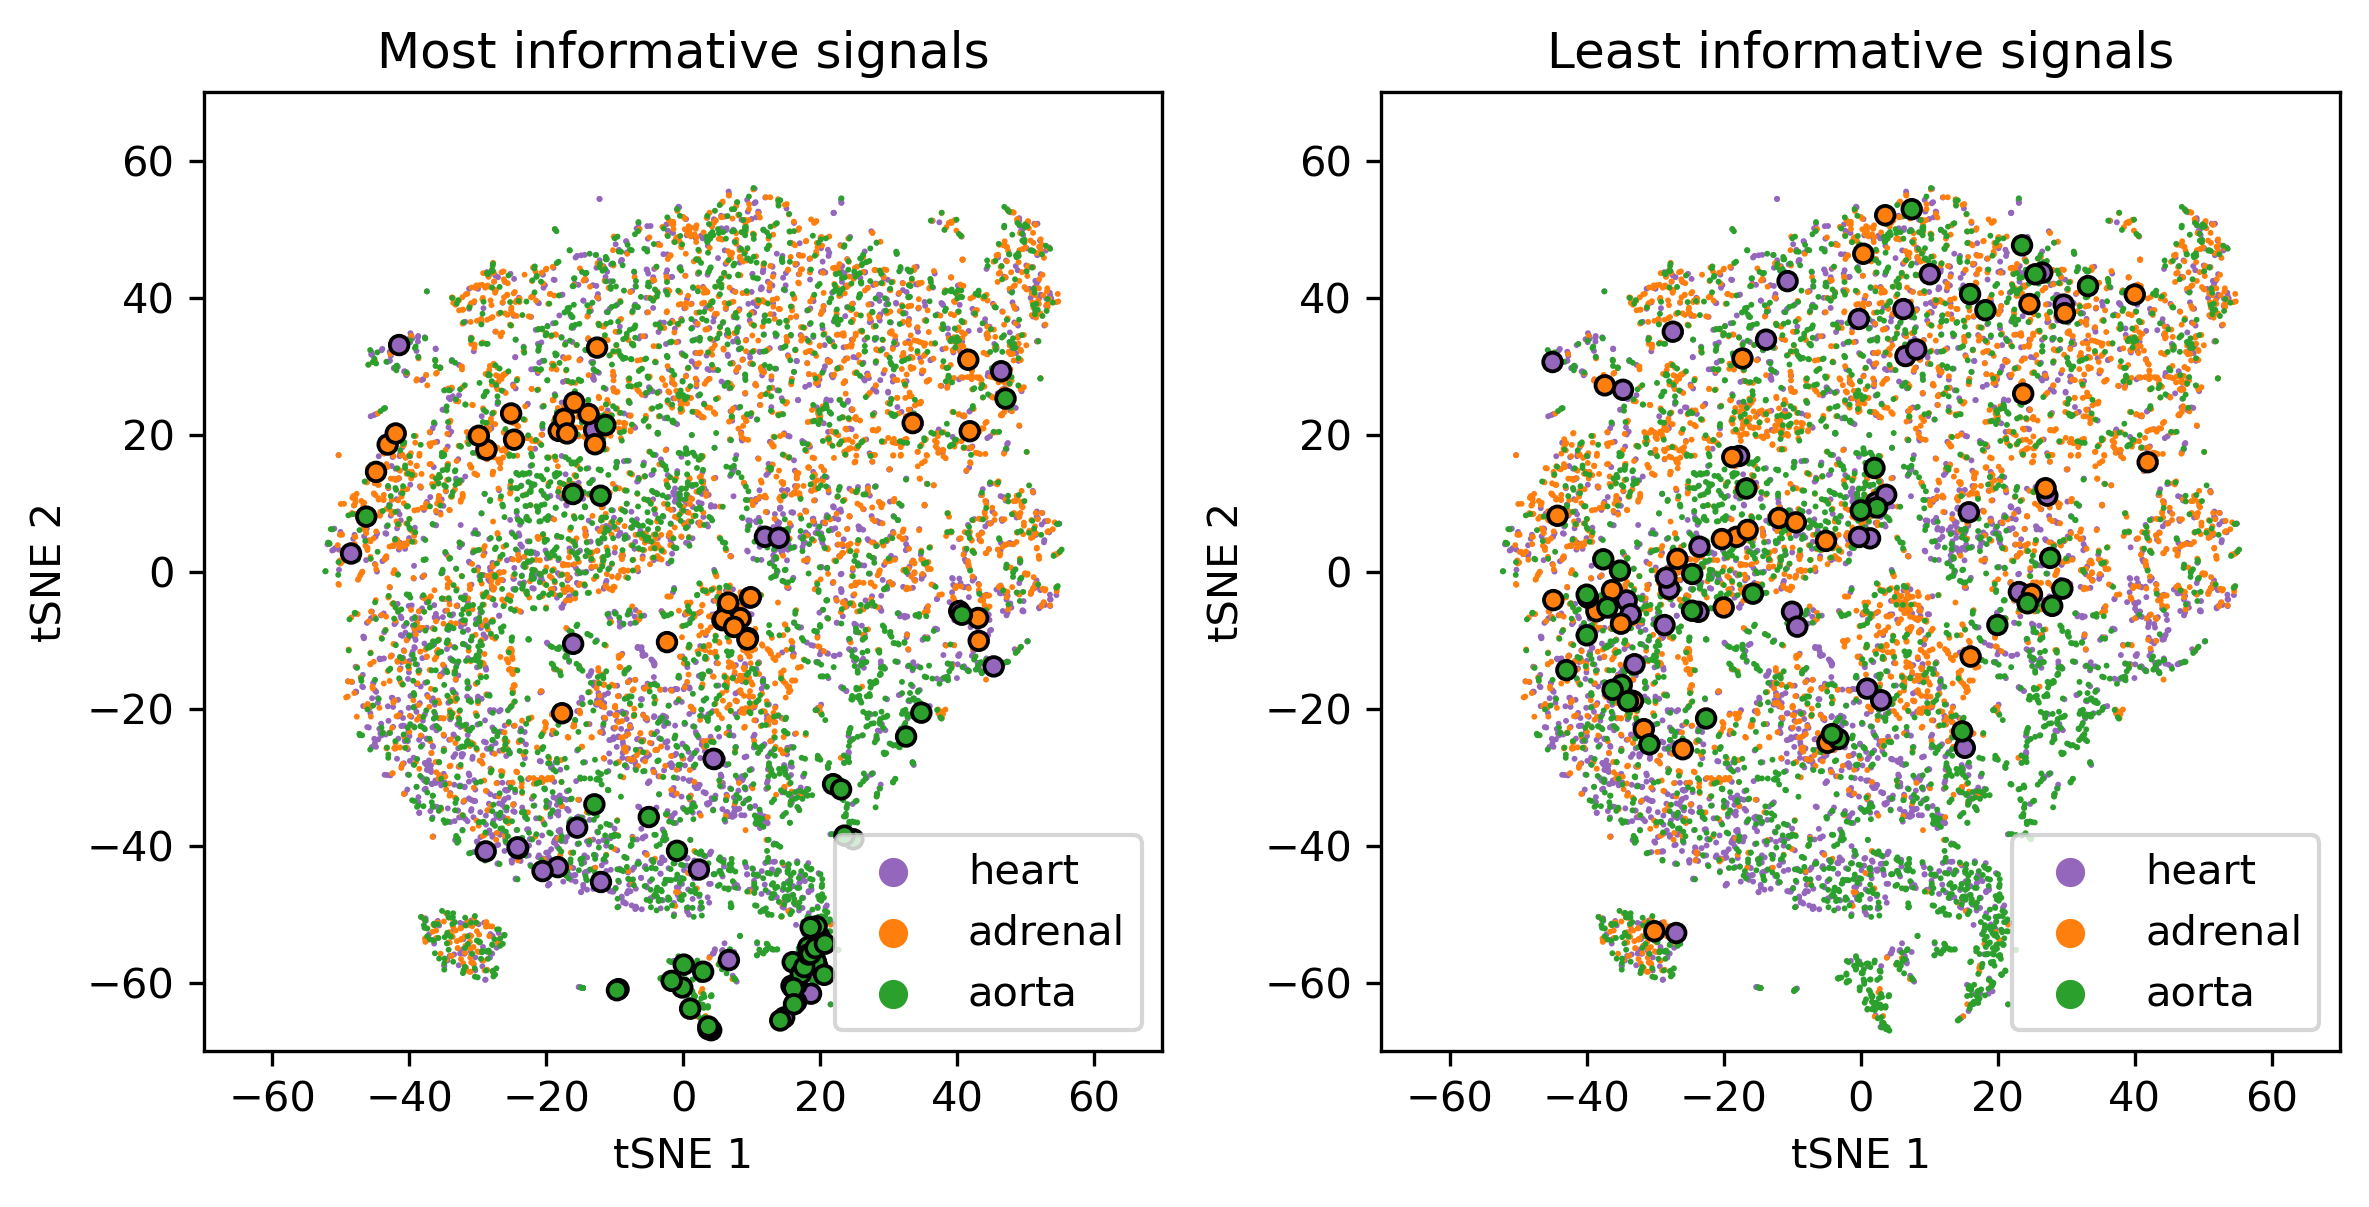

In [62]:
size = 8
lw = 0 

fig, axs = plt.subplots(1,2,figsize=(8,14), dpi=300)

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': [labels_key[x] for x in labels]})

xlim = (-70, 70)
ylim = (-70, 70)

sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', palette=palette_tab10mod, data=tsne_result_df, s=size, marker='.', linewidth=lw, ax=axs[0])
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', palette=palette_tab10mod, data=tsne_result_df.loc[informative_signals_dtwindex[::10]], s=80, marker='.', linewidth=0.9, ax=axs[0], edgecolor='black', legend=False)
axs[0].set_title(f'Most informative signals')
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)
axs[0].set_xlabel('tSNE 1')
axs[0].set_ylabel('tSNE 2')
axs[0].set_aspect('equal')

sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', palette=palette_tab10mod, data=tsne_result_df, s=size, marker='.', linewidth=lw, ax=axs[1])
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', palette=palette_tab10mod, data=tsne_result_df.loc[leastinformative_signals_dtwindex[::10]], s=80, marker='.', linewidth=0.9, ax=axs[1], edgecolor='black', legend=False)
axs[1].set_title(f'Least informative signals')
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)
axs[1].set_xlabel('tSNE 1')
axs[1].set_ylabel('tSNE 2')
axs[1].set_aspect('equal')
# remove legend titles
handles, lab = axs[0].get_legend_handles_labels()
axs[0].legend(handles=handles, labels=lab)
handles, lab = axs[1].get_legend_handles_labels()
axs[1].legend(handles=handles, labels=lab)
plt.tight_layout()
plt.savefig('../figs/knn8.MostvsLeastInformative.png',dpi=300, bbox_inches='tight')
plt.show()

## Venn diagram representation of class similarity

For this analysis, consider a higher number of clusters to get clusters that accurately represent signals from one tissue type or shared between different tissue types.

In [63]:
sns.set_palette("tab10")

In [64]:
clust_number = 120

In [65]:
kmedoids = KMedoids_mod(n_clusters=clust_number, random_state=0, metric='precomputed', max_iter=300).fit(dtw_mat_inform)
clust_labels = kmedoids.labels_
clust_centers = kmedoids.cluster_centers_

#### Stablish thlds to categorize each cluster in one of the 3 categories

Stablish a thld value of signals for each cluster. This 0.25 means that a cluster must have more than 25% of signals from one class to be considered as a cluster attributable to that class. This way, clusters are assigned to one, two or three classes.

In [66]:
thld = 0.25

num_labels = len(labels_key.values())
lbl_by_cluster = np.zeros((clust_number,num_labels))
for signal_label, signal_cluster in zip(labels_inform, clust_labels):
    lbl_by_cluster[signal_cluster, signal_label] += 1
lbl_by_cluster_norm = normalize(lbl_by_cluster, axis=1, norm='l1')
lbl_by_cluster_norm_df = pd.DataFrame(lbl_by_cluster_norm)

In [67]:
labels_key

{0: 'heart', 1: 'adrenal', 2: 'aorta'}

Better use this version to classify each signal into one of the options

In [68]:
cluster_classes = {}
for i, clust in enumerate(lbl_by_cluster_norm > thld):
    clust_type = str(np.where(clust)[0])
    cluster_classes[i] = clust_type

Classify the signals into this classes depending on the cluster they belong to

In [69]:
# initialize dictionary with the cluster classes and counters at zero
clust_sign_count = {}
for cltype in np.unique(list(cluster_classes.values())):
    clust_sign_count[cltype] = 0

In [70]:
# now just iterate by each signal labeled according to its cluster and sum to the corresponding type
for signclust in clust_labels:
    clust_sign_count[cluster_classes[signclust]] += 1

In [71]:
clust_sign_count

{'[0 1 2]': 10,
 '[0 1]': 29,
 '[0 2]': 157,
 '[0]': 92,
 '[1 2]': 49,
 '[1]': 294,
 '[2]': 349}

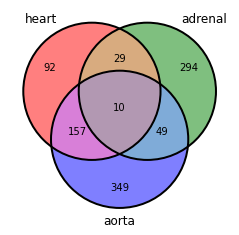

In [72]:
cluster_venn(clust_sign_count, list(labels_key.values()), True, True, savepath='../figs/knn9.VennDiagram.png')